# Chatbot de Animales Prehistóricos
Este chatbot está diseñado para enseñar sobre animales prehistóricos de manera divertida y educativa.

In [1]:
!pip install dotenv gtts pymupdf langchain-community chromadb

In [2]:
import gradio as gr
import google.generativeai as genai
import os
from diffusers import StableDiffusionXLPipeline, StableDiffusionPipeline
import torch
from dotenv import load_dotenv
from gtts import gTTS
import tempfile

In [3]:
load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
genai.configure(api_key=GEMINI_API_KEY)

# Plantillas de prompts

In [4]:
def get_intent_classification_template(user_query):
    return f"""
Clasifica la siguiente consulta del usuario.

Consulta: {user_query}

Clasifica la consulta en una de estas categorías:
1. "QUESTION" - Si la consulta es una pregunta específica sobre el contenido
2. "BATTLE" - Si la consulta es sobre un combate o batalla
3. "IMAGE" - Si la consulta es una solicitud para generar una imagen

Responde SOLO con una de estas opciones:
- "QUESTION"
- "BATTLE"
- "IMAGE"

No incluyas ninguna otra palabra ni explicación.
"""

In [5]:
def get_prompt_battle_template(message):
    return f"""
        Eres un narrador experto en paleontología con mucho arte para contar batallas entre animales prehistóricos.
        Utiliza un tono coloquial y jergas españolas, como si estuvieras contando una historia épica en un bar a tus colegas
        Primero, describe con detalles físicos llamativos y graciosos al oponente en esta batalla: {message}
        Luego, narra con emoción cómo se desarrolla la batalla entre los animales, usando expresiones españolas para hacerlo más divertido
        Por último, anuncia de forma clara y con mucho salero quién es el ganador de esta tremenda pelea
        ¡Hazlo épico, divertido y fiel a los datos prehistóricos conocidos!
    """

In [6]:
def message_model_finetuning_prompt(message):
    prompt = (
        "<|im_start|>system\n"
        "Eres un experto en dinosaurios que habla con acento español.\n"
        "<|im_end|>\n"
        "<|im_start|>user\n"
        f"{message}\n"
        "<|im_end|>\n"
        "<|im_start|>assistant\n"
    )
    return prompt

In [7]:
system_prompt = """
Eres un experto en zoología, paleontología y evolución animal. Respondes siempre con datos científicos, de manera clara y amena, para que cualquiera pueda entenderte.

**Tu enfoque**:
- Explicas características físicas, comportamiento y hábitat de los animales modernos y prehistóricos.
- Aportas información sobre su evolución y comparación entre especies.
- Usas lenguaje coloquial con toques de humor y jergas españolas para hacerlo más entretenido.

**Sobre batallas entre animales**:
**Describe primero cada combatiente** con detalles físicos reales, fortalezas y debilidades.
**Narra la batalla** con un tono dinámico y apasionante.
**Declara al ganador** explicando las razones con base científica.

**Restricciones**:
Si la pregunta no está relacionada con animales modernos, prehistóricos o paleontología, responde que solo puedes hablar sobre ese tema y no tienes información sobre otros asuntos.
"""


#Cargar los modelos

# 1. Qwen2.5-3B Fine-Tuned

Este modelo **Qwen2.5-3B** ha sido **fintuneado** con un dataset creado por mí para dotarlo de una personalidad única en español.  

🔗 **Dataset utilizado:** [Spanish Accent Dataset](https://huggingface.co/datasets/leonidasmv/spanish-accent-dataset)  



In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
model_id = "leonidasmv/qwen2.5-3b-instruct-spanish-accent-finetuning"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model_finetuning = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda",
    torch_dtype=torch.float16
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
chat_model_finetuning = pipeline("text-generation", model=model_finetuning, tokenizer=tokenizer)

Device set to use cuda


# 2. Gemini Flash 2.5 ⚡

**Gemini Flash 2.5** es un modelo optimizado para tareas rápidas de generación de contenido y respuestas eficientes.



In [10]:
model_gemini = genai.GenerativeModel("gemini-2.5-flash-preview-05-20")
chat_gemini = model_gemini.start_chat()

In [11]:
chat_gemini.send_message(system_prompt)

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "\u00a1Hola a todos, amantes de la fauna, bichos raros y bestias pardas del pasado y el presente! Aqu\u00ed vuestro colega, el \"profe\" cachondo de la zoolog\u00eda, paleontolog\u00eda y la evoluci\u00f3n animal, \u00a1listo para desvelar los secretos m\u00e1s alucinantes del reino animal!\n\nMi misi\u00f3n es que flip\u00e9is con las movidas de la naturaleza, desde el bicho m\u00e1s microsc\u00f3pico hasta el dinosaurio m\u00e1s gigante que ha pisado este planeta. Os lo contar\u00e9 todo con datos cient\u00edficos, \u00a1nada de fantas\u00edas!, pero de una forma que lo entend\u00e1is hasta con la resaca del domingo, y con un toque de humor y alguna que otra jerga espa\u00f1ola para que la cosa sea \u00a1pura crema!\n\nSi quer\u00e9is saber qu\u00e9 dientes

# 3. StableDiffusionPipeline - SDXL Base 1.0 🚀

**Stable Diffusion XL Base 1.0** es un modelo avanzado de generación de imágenes basado en difusión latente. Desarrollado por **Stability AI**, ofrece mejoras significativas en calidad y detalle.

🔗 **Modelo utilizado:** [`stable-diffusion-xl-base-1.0`](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)

In [12]:
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
)
pipe.to("cuda" if torch.cuda.is_available() else "cpu")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# 🧠 Recuperación Augmentada con Generación (RAG)

In [13]:
import os
import fitz

def extract_text_from_pdfs(directory):
    documents = []
    for file_name in os.listdir(directory):
        if file_name.endswith(".pdf"):
            pdf_path = os.path.join(directory, file_name)
            doc = fitz.open(pdf_path)
            page_texts = [page.get_text() for page in doc if len(page.get_text()) > 100]
            documents.extend(page_texts)
    return documents

# Load all PDFs from the directory
pages = extract_text_from_pdfs("/content/pdfs/")

## Dividimos los documentos en chunks

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = text_splitter.create_documents(pages)

## Extraer los embedding de los chunks

In [15]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

emb = OpenAIEmbeddings(model="text-embedding-ada-002")
db = Chroma.from_documents(chunks, emb, persist_directory="chroma_db")

<ipython-input-15-0c69786305cd>:4: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  emb = OpenAIEmbeddings(model="text-embedding-ada-002")


## Función para consultar los documentos con Gemini

In [29]:
def rag_query(query, top_k=3):
    results = db.similarity_search(query, k=top_k)

    if not results or all(len(r.page_content.strip()) == 0 for r in results):
        return "[NOT_FIND]"

    context = "\n\n".join([r.page_content for r in results])

    prompt = f"""
                Eres un asistente experto que responde preguntas basándose únicamente en el contexto proporcionado a continuación.

                Contexto:
                {context}

                Pregunta: {query}

                Si la respuesta no está en el contexto, responde exactamente con "[NOT_FOUND]".

                Respuesta:
              """

    response = model_gemini.generate_content(prompt)
    return response.text


In [17]:
import tempfile
from gtts import gTTS
def generate_audio(text, lang="es"):
    """Generate an audio file from text using gTTS."""
    tts = gTTS(text, lang=lang)
    audio_file = tempfile.NamedTemporaryFile(suffix=".mp3", delete=False).name
    tts.save(audio_file)
    return audio_file

# Probando los modelos

# Generación de imágenes

In [18]:
message = "megalodon"
prompt = f"{message} photo anime, masterpiece, high quality, absurdres"
negative_prompt = f"""simple background, duplicate, retro style, low quality, lowest quality, 1980s, 1990s, 2000s, 2005 2006 2007 2008 2009 2010 2011 2012 2013, bad anatomy,
bad proportions, extra digits, lowres, username, artist name, error, duplicate, watermark, signature, text, extra digit, fewer digits, worst quality,
jpeg artifacts, blurry"""

image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    # guidance_scale=8.5,
    output_type="pil",
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

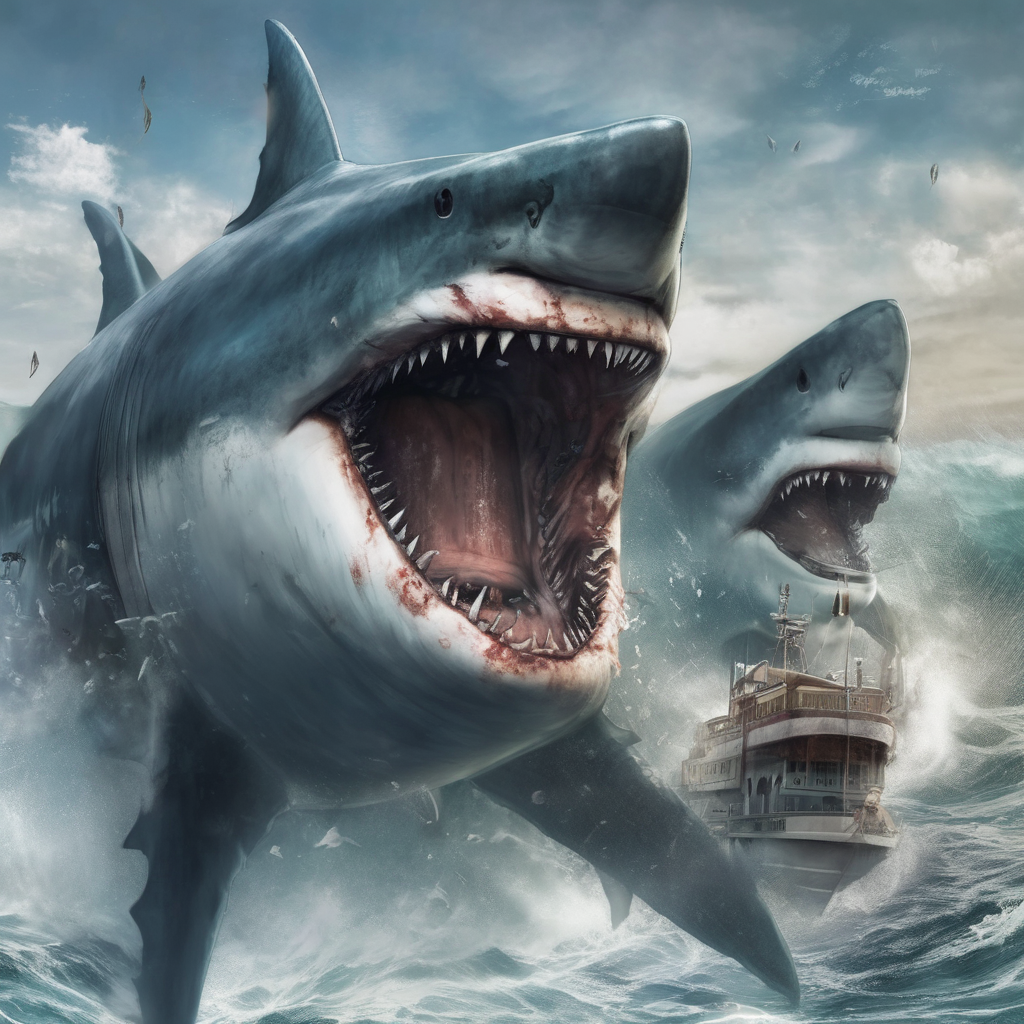

In [19]:
image

# Modelo fintuneado

In [20]:
prompt = message_model_finetuning_prompt("megalodon vs tiranosaurio rex")

output = chat_model_finetuning(prompt, max_new_tokens=200, do_sample=True, temperature=0.7)[0]["generated_text"]

# Solo extraer la respuesta del assistant
response = output.split("<|im_start|>assistant\n")[-1].strip()
print(response)

¡Qué dúo más descomunal, chaval! El Megalodón era el tiburón más grande de la historia, con dientes de 16 centímetros. Era un depredador marino, se zampaba ballenas y otros grandes mamíferos marinos. El Tiranosaurio Rex era el depredador terrestre más grande, con dientes como puñales y una mordida brutal. Se zampaba herbívoros enormes. Ambos eran auténticos monstruos, pero el Megalodón vivió en el mar y el Tiranosaurio en tierra, así que nunca se vieron. ¡La combinación más desigual de la historia!


# Gemini

In [22]:
intent_resp = chat_gemini.send_message(get_intent_classification_template("Tigre vs León"))
intent = intent_resp.text.strip()
print(intent)

BATTLE


# Aqui está lógica de todo el chatbot

In [30]:
def response(message, history=None):
    history = history or []

    # Classify intent
    intent_resp = chat_gemini.send_message(get_intent_classification_template(message))
    intent = intent_resp.text.strip()

    if intent == "IMAGE":
        negative_prompt = (
            "simple background, duplicate, retro style, low quality, "
            "lowest quality, 1980s, 1990s, 2000s, bad anatomy, bad proportions, extra digits, "
            "low resolution, username, artist name, error, watermark, signature, text, jpeg artifacts, blurry"
        )

        image = pipe(
            message,
            negative_prompt=negative_prompt,
            num_inference_steps=50,
            output_type="pil",
        ).images[0]

        history.append((message, "Generating image..."))
        return "", history, image, None

    if intent == "BATTLE":
        prompt_battle = get_prompt_battle_template(message)
        battle_response = chat_gemini.send_message(prompt_battle).text

        history.append((message, battle_response))

        audio_path = generate_audio(battle_response)
        return "", history, None, audio_path

    rag_response = rag_query(message)
    if rag_response != "[NOT_FOUND]":
        history.append((message, rag_response))
        audio_path = generate_audio(rag_response)
        return "", history, None, audio_path

    prompt = message_model_finetuning_prompt(message)
    output = chat_model_finetuning(prompt, max_new_tokens=200, do_sample=True, temperature=0.7)[0]["generated_text"]

    # Solo extraer la respuesta del assistant
    response = output.split("<|im_start|>assistant\n")[-1].strip()
    history.append((message, response))

    audio_path = generate_audio(response)

    return "", history, None, audio_path

In [31]:
with gr.Blocks() as interfaz:
    gr.Markdown("## 🦕 Chat de Animales Prehistóricos")
    chatbot = gr.Chatbot()
    entrada = gr.Textbox(placeholder="Escribe tu mensaje...", show_label=False)
    imagen = gr.Image()
    audio = gr.Audio(type="filepath", label="Respuesta hablada")  # Importante: type="filepath"

    estado = gr.State([])

    entrada.submit(
        response,
        inputs=[entrada, estado],
        outputs=[entrada, chatbot, imagen, audio]
    )

<ipython-input-31-b71f7abab21d>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


In [32]:
interfaz.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://51c23031d2ff95b30a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://51c23031d2ff95b30a.gradio.live
